In [1]:
%pylab inline
import random as rnd
from tradesys import *
from deap import base, creator, tools, algorithms
import operator
from IPython.parallel import Client
import time

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
from IPython.display import clear_output, display
from empyrical import sortino_ratio, calmar_ratio, omega_ratio


In [3]:
# All signals used in evolution
all_signals = ["CROSSES(MA(5), MA(26))", "CROSSES(MA(5), PRICE)", "CROSSES(PRICE, PRICE)", "CROSSES(RSI(5), RSI(26))",
               "RSI(14) > F(70.0)", "RSI(14) < F(30.0)", "B", 
               "ADX(14) > F(80.0)", "ADX(14) < F(20.0)",
               "UP(MA(14))", "DOWN(MA(14))", 
               "UP(RSI(14))", "DOWN(RSI(14))", 
               "UP(ADX(14))", "DOWN(ADX(14))", 
               ]

In [4]:
ex = eval_stree_expr(all_signals[0])
exl = ex.flatten_tree()
for si in exl:
    print(si.get_parameters(True))

{}
{'period': 5}
{'period': 26}


In [5]:
# The individual is a list of signals, that is later combined
# to form a simple tree (a or b ~ c or d ~ e or f ~ trailing_stop ~ take_profit)
def random_signal():
    return rnd.choice(all_signals)
def random_op():
    return rnd.choice(['or', 'and'])

class MyIndividual(object):
    def __init__(self):
        self.signals = []
        self.ops = []
        self.trail_stop = 5.0
        self.take_profit = 5.0
        
    def get_strategy(self):
        if len(self.signals)!= 6 or len(self.ops) != 3:
            raise TypeError("Uninitialized individual!")
        return (
"""
BUY_IF (%s) %s (%s);

SELL_IF (%s) %s (%s);

CLOSE_IF ((CURRENT_PROFIT < F(0)) and (BARS_SINCE_ENTRY > I(800))) or ((%s) %s (%s));

"""
                % (self.signals[0], self.ops[0], self.signals[1], 
                   self.signals[2], self.ops[1], self.signals[3], 
                   self.signals[4], self.ops[2], self.signals[5], 
                   #self.trail_stop, self.take_profit
                  ))
    
# Probabilities
Crossover_Prob = 0.5
Mutation_Prob = 0.05

Mutation_Replace_Signal_Prob = 0.1 # probability for any signal to be replaced, otherwise it will only modify parameters
Mutation_Replace_Parameter_Prob = 0.25 # probability for any parameter of a signal to be replaced witha random value

Min_TrailStop = 0.05
Max_TrailStop = 1.0

Min_TakeProfit = 1.0
Max_TakeProfit = 5.0

def get_random_individual(ind_class):
    ind = ind_class()
    ind.signals = [random_signal() for _ in range(6)] # make 6 random signals or signal trees
    ind.ops = [random_op() for _ in range(3)] # the ops connecting them
    ind.trail_stop = rnd.uniform(Min_TrailStop, Max_TrailStop)
    ind.take_profit = rnd.uniform(Min_TakeProfit, Max_TakeProfit)
    return ind

# Mate two individuals
# They are both modified in place
# The function returns a tuple with the new individuals
def crossover(ind1, ind2):
    # go through all signals and randomly swap them
    for i in range(len(ind1.signals)):
        if rnd.random() < 0.5:
            ind1.signals[i], ind2.signals[i] = ind2.signals[i], ind1.signals[i]
    # go through all ops and randomly swap them
    for i in range(len(ind1.ops)):
        if rnd.random() < 0.5:
            ind1.ops[i], ind2.ops[i] = ind2.ops[i], ind1.ops[i]
    # randomly choose between swap or merge for trail_stop
    merge = rnd.random() < 0.5
    if merge:
        avg = (ind1.trail_stop + ind2.trail_stop)/2.0
        ind1.trail_stop, ind2.trail_stop = avg, avg
    else:
        swap = rnd.random() < 0.5
        if swap:
            ind1.trail_stop, ind2.trail_stop = ind2.trail_stop, ind1.trail_stop
    return (ind1, ind2)

# Mutate an individual
# It's modified in place
# The function returns the new individual
def mutation(ind):
    # sometimes mutate the trail_stop/take profit
    ts = rnd.random() < 0.2
    if ts:
        replace = rnd.random() < 0.5
        if replace:
            ind.trail_stop = rnd.uniform(Min_TrailStop, Max_TrailStop)
        else:
            ind.trail_stop += rnd.uniform(-0.2, 0.2)
            ind.trail_stop = clip(ind.trail_stop, Min_TrailStop, Max_TrailStop)
    tp = rnd.random() < 0.2
    if tp:
        replace = rnd.random() < 0.5
        if replace:
            ind.take_profit = rnd.uniform(Min_TakeProfit, Max_TakeProfit)
        else:
            ind.take_profit += rnd.uniform(-0.2, 0.2)
            ind.take_profit = clip(ind.take_profit, Min_TakeProfit, Max_TakeProfit)
    
    # sometimes mutate ops
    op_mutation = rnd.random() < 0.5
    if op_mutation:
        # mutate random op
        idx = rnd.choice(range(len(ind.ops)))
        ind.ops[idx] = random_op()
    
    # sometimes mutate signals
    signal_mutation = rnd.random() < 0.5
    if signal_mutation:
        # mutate random signal
        idx = rnd.choice(range(len(ind.signals)))
        if rnd.random() < Mutation_Replace_Signal_Prob:
            ind.signals[idx] = random_signal()
        else: # tinker with the parameters in the tree
            for i,s in enumerate(ind.signals):
                ex = eval_stree_expr(s)
                exl = ex.flatten_tree()
                for si in exl:
                    # si is a single signal object
                    d = si.get_parameters(True) # the dict with parameters, can be empty
                    if d:
                        for k, v in d.items():
                            # mutate/replace d[k] according to type of value 
                            replace = rnd.random() < Mutation_Replace_Parameter_Prob
                            if v.__class__.__name__ == 'int':
                                if replace:
                                    d[k] = rnd.randint(1, 64)
                                else:
                                    d[k] += rnd.randint(-3, 3)
                            if v.__class__.__name__ == 'float':
                                if replace:
                                    d[k] = rnd.uniform(0.0, 100.0)
                                else:
                                    d[k] += rnd.uniform(-1.0, 1.0)
                            if v.__class__.__name__ == 'bool':
                                if replace:
                                    d[k] = rnd.choice([True, False])
                        # write changes back to signal
                        si.set_parameters(d)
                # write changes back to signal tree
                ind.signals[i] = ex.print_str()
    return ind

In [6]:
get_random_individual(MyIndividual).get_strategy()

'\nBUY_IF (RSI(14) < F(30.0)) and (RSI(14) < F(30.0));\n\nSELL_IF (CROSSES(RSI(5), RSI(26))) or (CROSSES(RSI(5), RSI(26)));\n\nCLOSE_IF ((CURRENT_PROFIT < F(0)) and (BARS_SINCE_ENTRY > I(800))) or ((DOWN(ADX(14))) or (UP(MA(14))));\n\n'

In [7]:
# evolution stuff
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", MyIndividual, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("individual", get_random_individual, creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", crossover)
toolbox.register("mutate", mutation)
toolbox.register("select", tools.selTournament, tournsize=3)

In [8]:
# data to train on
train_data = DataMatrix()
train_data.load_tsys('data.tsys')
train_data.clip_dt(DateTime(2018,1), DateTime(2019,3))
list(train_data.dt)[0], list(train_data.dt)[-1]

(2018-01-01 12:00:00, 2019-02-28 11:00:00)

In [9]:
# backtest options
options = BacktestOptions()
options.commission = 0
options.slippage = 0.0
options.market_open_time = Time(0)
options.market_close_time = Time(0)

In [10]:
# fitness function
def evaluate_individual(s):

    num_tests = 10
    fits = []
    
    for test in range(num_tests):
        data = tradesys.engine_data.slice_idx(random.randint(0, 250), 99999999)

        info = tradesys.backtest(data, s, options=tradesys.engine_options)
        if info.num_trades > 80*1: # 80 per year seems to be the best (avg 1 trade per 3.125 business days)
            r = sortino_ratio(np.array([x.profit for x in list(info.list_of_trades)]))
        else:
            r = 0
        
        fits.append(r)
        
    return sum(fits) / float(len(fits)), 

In [11]:
PopSize = 100
Generations = 50

pop = toolbox.population(n=PopSize)

In [12]:
import tradesys
tradesys.engine_data = train_data
tradesys.engine_options = options

In [13]:
%%time

from tqdm import tqdm

# evaluate all individuals for a start
fitnesses = []
strategies = [x.get_strategy() for x in pop]
#amr = lbview.map(evaluate_individual, strategies, ordered=True, block=False)
#for i,fitness in tqdm(enumerate(amr)):
#    fitnesses.append(fitness)
for i,s in tqdm(enumerate(strategies)):
    fitnesses.append( evaluate_individual(s) )
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
best_ever = pop[0]

100it [00:38,  2.67it/s]

CPU times: user 38.2 s, sys: 69.1 ms, total: 38.3 s
Wall time: 38.3 s


In [14]:
stagnation = 0

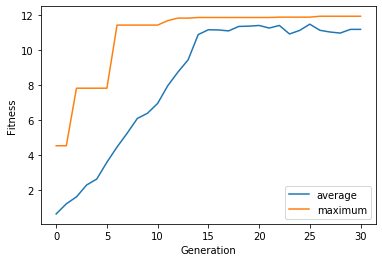

23it [00:08,  2.67it/s]


In [15]:
bestf_ever = -99999999999
min_h, max_h, avg_h, gen_h = [], [], [], []

f, ax = plt.subplots()

# Begin the evolution
try:
    for g in range(Generations):
        #print("-- Generation %i --" % g)

        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if rnd.random() < Crossover_Prob:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if rnd.random() < Mutation_Prob:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = []
        strategies = [x.get_strategy() for x in invalid_ind]
        #amr = lbview.map(evaluate_individual, strategies, ordered=True, block=False)
        #for i, fitness in enumerate(amr):
        #    fitnesses.append(fitness)
        for i,s in tqdm(enumerate(strategies)):
            fitnesses.append( evaluate_individual(s) )
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # replace the population with the offspring
        pop[:] = offspring
        
        # elitism - the last one is always the best ever
        pop[-1] = best_ever

        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        if fits:
            min_index, min_value = min(enumerate(fits), key=operator.itemgetter(1))
            max_index, max_value = max(enumerate(fits), key=operator.itemgetter(1))

            length = len(pop)
            mean = sum(fits) / length

            min_h.append(min_value)
            max_h.append(max_value)
            avg_h.append(mean)
            gen_h.append(g)

            clear_output(wait=True)

            cla()

            plt.plot(gen_h, avg_h, label="average");
            #plt.plot(gen_h, min_h, label="minimum");
            plt.plot(gen_h, max_h, label="maximum");
            plt.xlabel("Generation");
            plt.ylabel("Fitness");
            plt.legend(loc="lower right");

            display(f)

            best = pop[max_index]
            bestf = fits[max_index]

            if bestf > bestf_ever:
                stagnation = 0
                bestf_ever = bestf
                best_ever = best
            else:
                stagnation += 1

            #if stagnation:
            #    print 'stagnation:', stagnation
except KeyboardInterrupt:
    pass

plt.close()

In [16]:
s = best_ever.get_strategy()
s

"\nBUY_IF (BOOL(val=false)) and (CROSSES(RSI(5), RSI(26)));\n\nSELL_IF (UP(ADX(14))) and (CROSSES(MA(5), PRICE));\n\nCLOSE_IF ((CURRENT_PROFIT < F(0)) and (BARS_SINCE_ENTRY > I(800))) or ((CROSSES(PRICE(bars_back=0, price='close'), PRICE(bars_back=0, price='close'))) or ((RSI(bars_back=0, period=19, price='close')) > (FLOAT(val=70.10413956400635))));\n\n"

In [25]:
train_data = DataMatrix()
train_data.load_tsys('data.tsys')
train_data.clip_dt(DateTime(2019,1), DateTime(2019,3))
list(train_data.dt)[0], list(train_data.dt)[-1]

(2019-01-01 12:00:00, 2019-02-28 11:00:00)

--------------------
Profit factor: 0.70
Trades: 21
Profit / Loss trades: 9 (42.9%) / 12 (57.1%)
Gross profit: $12682.83
Gross loss: $-18216.04
Net profit: $-5533.21
Long / Short positions: 0 (0.0%) / 21 (100.0%)
--------------------



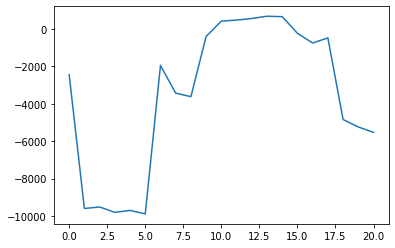

In [26]:
info = backtest(train_data, s, options=options, prt=1, plot=1);

In [19]:
#info = backtest(db.get_symbol('EURUSD', period=15, period_type='m', 
#                date_range=((2014,4),(2014,6)), resample='base'),
#                s, options=options, prt=1, plot=1);

In [20]:
(info.average_runup_per_trade, info.average_profit_per_trade, info.average_loss_per_trade, info.average_drawdown_per_trade)

(1697.8362857142868,
 1660.4340000000018,
 -2076.7500000000005,
 -2083.4345714285714)